# Red Queen Observation

## Imports

In [1]:
import sys
import os
import os.path
import io
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gamma
from scipy import integrate
import seaborn as sns
import numpy.random as nprand
from scipy.stats import gamma

## Read file

In [2]:
def readfiles(pathtofile, file_name, ext_name,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_file = pathtofile+file_name+"."+ext_name
    data = dict()
    params = []
    nbline=1
    with io.open(data_file,'r') as f:
        reader = csv.reader(f)
        firstline = True
        for line in reader:
            lin = line[0].split()
            if not firstline:
                if nbline>=line_to_begin:
                    for j in range(len(lin)):
                        if ext_name == "allele":
                            if float(lin[5])>minq and float(lin[6])>minfert:
                                if withoutneutral==1 and float(lin[1]) != -3 :
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j])) 
                                elif withoutneutral==0:
                                    if withoutnan == 0:
                                        if logfert==True and (j==6 or j==9):
                                            data[params[j]].append(np.log(float(lin[j])))
                                        else:
                                            data[params[j]].append(float(lin[j]))
                                    elif withoutnan ==1 :
                                        if lin[5]!="-nan" and lin[6]!="-nan":
                                            if logfert==True and (j==6 or j==9):
                                                data[params[j]].append(np.log(float(lin[j])))
                                            else:
                                                data[params[j]].append(float(lin[j]))
                        elif ext_name == "trace" and logfert==True and (j==6 or j==14):
                            data[params[j]].append(np.log(float(lin[j])))
                        else :
                            data[params[j]].append(float(lin[j]))
                nbline=nbline+1
            else:
                for j in lin:
                    data[j]=[]
                    params.append(j)
                firstline = False
                nbline=nbline+1
    return (data)

In [3]:
path_to_file_init = "../../../analyses/"

### Colorblind palette

In [4]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## Functions for plot

In [5]:
def graph_per_allele(target_folder_path, file_name, ext_name, x_axis_param, y_axis_param,withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin):
    data_all = readfiles(target_folder_path, file_name, 'allele',withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    data_trace = readfiles(target_folder_path, file_name, 'trace',withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
    x_per_allele=dict()
    y_per_allele=dict()
    for i in range(len(data_all["Generation_number"])):
        cle = data_all['Allele_number'][i]
        if ((str(cle) in x_per_allele) == False and cle!=-3):
            x_per_allele[str(cle)]=[]
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            y_per_allele[str(cle)]=[]
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
        elif ((str(cle) in x_per_allele) == True and cle!=-3):
            x_per_allele[str(cle)].append(data_all[x_axis_param][i])
            if y_axis_param=="selection":
                sel_coef=np.log(data_all['fertility_analytic'][i])-np.log(data_trace['fertility_analytic'][int(data_all["Generation_number"][i]/100)])
                y_per_allele[str(cle)].append(sel_coef)
            else:
                y_per_allele[str(cle)].append(data_all[y_axis_param][i])
    return(x_per_allele,y_per_allele)

In [9]:
def plot_regim_per_allele(target_folder_path, file_name, ext_name, x_param, y_params, withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters):
    figure=plt.figure(figsize=(8,8))
    index_line_plot=1
    for k in range(2):
        index_line=1
        legend_list=["Frequency of\n PRDM9 alleles ("r"$f_i$)","Proportion of\n active sites ("r"$\theta_i$)"]
        figure.patch.set_facecolor('white')
        figure.patch.set_alpha(0)
        for i in y_params:
            max_y=0
            plt.subplot(2*len(y_params),1,index_line_plot) 
            (X,Y)=graph_per_allele(target_folder_path[k], file_name[k], ext_name, x_param, i, withoutneutral,withoutnan,minq,minfert,logfert,line_to_begin)
            index_color=0
            for j in range(allelenbmax[k]-allelenbmin[k]):
                allele_nb=allelenbmin[k]+j
                nameallelelist=[str(allele_nb),'.0']
                nameallele=''.join(nameallelelist)
                if X.get(nameallele, 0)!=0:
                    if(float(nameallele)==boldallel[k]):
                        plt.plot(X[nameallele], Y[nameallele],linewidth=3,color=CB_color_cycle[index_color])
                    else:
                        plt.plot(X[nameallele], Y[nameallele],color=CB_color_cycle[index_color])
                    if(max_y<max(Y[nameallele])):
                        max_y=max(Y[nameallele])
                    index_color+=1
                    index_color=index_color%8
            plt.ylabel(legend_list[index_line-1],fontsize=11)
            plt.text(x=x_letter,y=y_letter[k][index_line-1],s=letters[k][index_line-1],fontweight='bold',fontsize=16)
            if index_line==len(y_params):
                plt.xlabel("Number of generations",fontsize=12)
            plt.title(title)
            if i=="selection":
                plt.axhline(y=0, color='black',linestyle=':')
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.xlim(xmin,xmax)
            plt.ylim(ymin[k][index_line-1],ymax[k][index_line-1])
            plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.25)
            index_line+=1
            index_line_plot+=1
            plt.grid()
            figure.tight_layout()

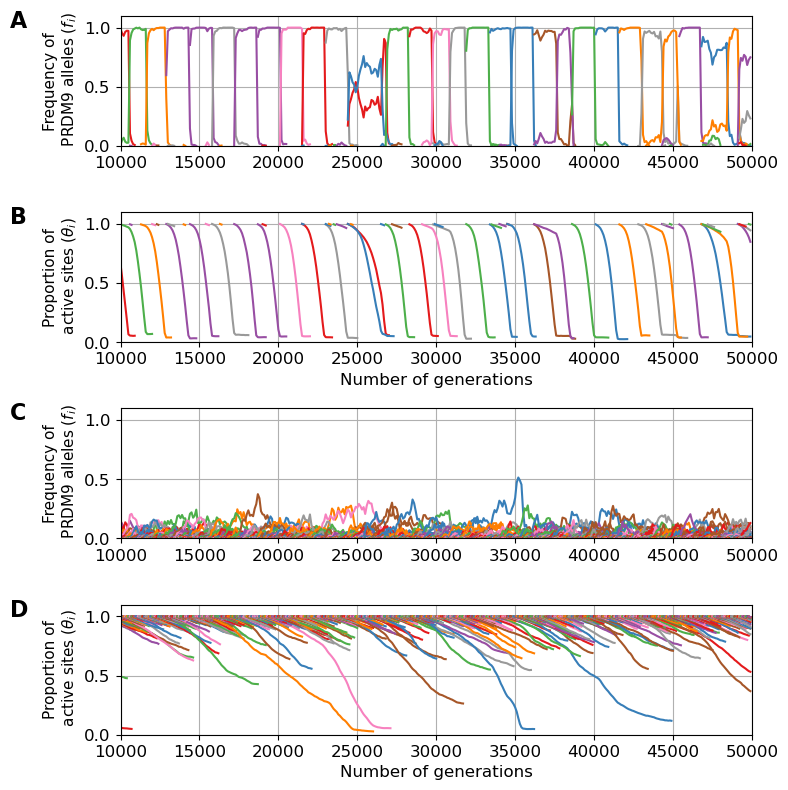

In [10]:
u_1="5e-6"
v_1="5e-5"
path_to_file_to_plot_1 = "scaling_bidim_U_V_COasym/scaling_bidim_1/scaling_V_"+v_1+"/"
file_to_plot_1 = "Run_U_"+u_1
u_2="5e-4"
v_2="5e-5"
path_to_file_to_plot_2 = "scaling_bidim_U_V_COasym/scaling_bidim_1/scaling_V_"+v_2+"/"
file_to_plot_2 = "Run_U_"+u_2
ext_of_file = "allele"
x_parameter = "Generation_number"
y_parameters = ["Frequency","Activity"]
withoutneutral = 0
withoutnan = 0
minq = 0
minfert = 0
logfert = 0
line_to_begin = 0
allelenbmin_1 = 0
allelenbmax_1 = 10000000
boldallel_1 = -1
allelenbmin_2 = 0
allelenbmax_2 = 10000000
boldallel_2 = -1
xmin = 10000
xmax = 50000
ymin_1=[0,0]
ymax_1=[1.1,1.1]
x_letter = 3000
y_letter_1 =[1,1]
title=""
letters_1=["A","B"]
ymin_2=[0,0]
ymax_2=[1.1,1.1]
x_letter = 3000
y_letter_2 = [1,1]
title=""
letters_2=["C","D"]

target_folder_path = [path_to_file_init+path_to_file_to_plot_1,path_to_file_init+path_to_file_to_plot_2]
file_to_plot = [file_to_plot_1,file_to_plot_2]
allelenbmin = [allelenbmin_1,allelenbmin_2]
allelenbmax = [allelenbmax_1,allelenbmax_2]
boldallel = [boldallel_1,boldallel_2]
ymin = [ymin_1,ymin_2]
ymax = [ymax_1,ymax_2]
y_letter = [y_letter_1,y_letter_2]
letters = [letters_1,letters_2]

fig1=plot_regim_per_allele(target_folder_path, file_to_plot, ext_of_file, x_parameter,y_parameters,withoutneutral, withoutnan,minq,minfert,logfert,line_to_begin, allelenbmin, allelenbmax,boldallel,xmin,xmax,x_letter,y_letter,ymin,ymax,title,letters)

plt.savefig('S2_Fig.png', dpi=200, bbox_inches='tight')
